# Preparation

In [1]:
# data science
import pandas as pd
import numpy as np

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

import pythermalcomfort as ptc
import warnings

In [2]:
data_raw = pd.read_excel("../9_plotting_report/HR_compilation.xlsx")

In [3]:
data = data_raw

In [4]:
data

,Time,HR,RR,MS,SKINCONTACT,experiment_set,experiment_id,subid,Thermal,Traffic noise levels,Speech
0,2023-07-10 10:45:00.613,73,795,0.025007,1,1,1,1,NV fan 5,55,0
1,2023-07-10 10:45:01.432,73,819,0.025017,1,1,1,1,NV fan 5,55,0
2,2023-07-10 10:45:02.281,74,849,0.025026,1,1,1,1,NV fan 5,55,0
3,2023-07-10 10:45:03.157,73,876,0.025037,1,1,1,1,NV fan 5,55,0
4,2023-07-10 10:45:03.985,73,828,0.025046,1,1,1,1,NV fan 5,55,0
...,...,...,...,...,...,...,...,...,...,...,...
671106,2023-07-27 16:27:56.560,78,832,0.022182,1,6,6,36,NV fan 5,70,0
671107,2023-07-27 16:27:57.388,77,828,0.022192,1,6,6,36,NV fan 5,70,0
671108,2023-07-27 16:27:58.280,77,892,0.022202,1,6,6,36,NV fan 5,70,0
671109,2023-07-27 16:27:59.162,76,882,0.022213,1,6,6,36,NV fan 5,70,0


# Insert PMV into V6

In [27]:
master_data = pd.read_excel("../0_dataset_master/Experiment_edited_V6.xlsx")

In [28]:
master_data['pmv'] = master_data.apply(lambda row: ptc.models.pmv(row['T'], row['Tgl'], row['v_adj'], row['H'], 1, row['clo'], limit_inputs=False), axis=1)

# Frequency Domain Analysis

In [7]:
def frequency_domain(rri, fs):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rri, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [8]:
def FDA(rr, fs, correction=False):
    if correction:
        rr = rr.copy()
        rr = rr[np.abs(zscore(rr)) <= 2]

    # create interpolation function based on the rr-samples. 
    x = np.cumsum(rr) / 1000.0
    f = interp1d(x, rr, kind='cubic')

    # sample rate for interpolation
    steps = 1 / fs

    # now we can sample from interpolation function
    xx = np.arange(1, np.max(x), steps)
    try:
        rr_interpolated = f(xx)
    except Exception as e:
        xx = np.arange(min(x), np.max(x), steps)
        rr_interpolated = f(xx)
    results, fxx, pxx = frequency_domain(rr_interpolated, fs)
    return results

## Insert HRV into V7

In [29]:
new = master_data['Time_thermal'].str.split("-", n=1, expand=True)
master_data['New_Start_Date'] = pd.to_datetime(master_data['Start Date']).dt.date
master_data['New_End_Date'] = pd.to_datetime(master_data['Start Date']).dt.date
master_data['New_Start_Date'] = master_data['New_Start_Date'].astype(str) + ' ' + new[0]
master_data['New_End_Date'] = master_data['New_End_Date'].astype(str) + ' ' + new[1]
master_data['New_Start_Date'] = master_data['New_Start_Date'].astype('datetime64[ms]')
master_data['New_End_Date'] = master_data['New_End_Date'].astype('datetime64[ms]')

In [10]:
# hrv = [
#         'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
#         'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
#     ]

# result = []
# for index, row in master_data.iterrows():
#     sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time']) & (data['experiment_id']==int(row['Experiment id'][-1])) & (data['experiment_set']==int(row['Experiment set'][-1]))].copy()
#     try:
#         results = FDA(sliced.RR, 4)
#     except Exception as e:
#         print(sliced)
#         print(e)
#         raise e
#     resTemp = []
#     for item in hrv:
#         if item == "rr_mean":
#             resTemp.append(sliced.RR.mean())
#             continue
#         resTemp.append(results[item])
#     result.append(resTemp)

# master_data[hrv] = result

In [11]:
# master_data[hrv].describe()

,Power VLF (ms2),Power LF (ms2),Power HF (ms2),Power Total (ms2),LF/HF,Fraction LF (nu),Fraction HF (nu),rr_mean
count,3.060000e+02,3.060000e+02,306.000000,3.060000e+02,306.000000,306.000000,306.000000,306.000000
mean,2.383952e+06,6.324151e+05,17525.154399,3.033892e+06,3.605527,61.870873,38.129127,800.785140
std,1.652382e+07,3.321848e+06,70900.396511,1.980796e+07,8.252095,12.669504,12.669504,81.153223
min,4.626358e+02,4.866986e+02,230.545283,1.216007e+03,0.566368,36.158061,1.824407,663.085044
25%,1.052123e+03,9.497201e+02,629.892712,2.604071e+03,1.245209,55.460722,34.111719,740.857959
50%,1.370398e+03,1.474136e+03,986.621148,4.162457e+03,1.468436,59.488512,40.511488,788.853762
75%,2.228856e+03,2.402520e+03,2021.042495,7.300509e+03,1.931544,65.888281,44.539278,873.662849
max,1.299368e+08,2.478991e+07,460673.572687,1.551874e+08,53.812320,98.175593,63.841939,961.137482


In [12]:
# master_data.to_excel("../0_dataset_master/Experiment_edited_V7_rr_without_correction.xlsx", index=False)

In [31]:
hrv = [
        'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
        'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
    ]

result = []
for index, row in master_data.iterrows():
    sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time']) & (data['experiment_id']==int(row['Experiment id'][-1])) & (data['experiment_set']==int(row['Experiment set'][-1]))].copy()
    resTemp = []
    sliced = sliced[sliced['SKINCONTACT']==1]
    if sliced.empty:
        for item in hrv:
            resTemp.append(np.nan)
        result.append(resTemp)
        continue
    
    try:
        results = FDA(sliced.RR, 4, True)
    except ValueError as e:
        print(row['New_Start_Date'], row['New_End_Date'], row['Experiment set'], row['Experiment id'])
        print(e)
        for item in hrv:
            resTemp.append(np.nan)
        result.append(resTemp)
        continue
    except Exception as e:
        print(row['New_Start_Date'], row['New_End_Date'], row['Experiment set'], row['Experiment id'])
        print(len(sliced.RR))
        print(e)
        raise e
    
    for item in hrv:
        if item == "rr_mean":
            resTemp.append(sliced.RR.mean(axis=0))
            continue
        resTemp.append(results[item])
    result.append(resTemp)

master_data[hrv] = result

c:\Users\ZENI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 156, using nperseg = 156
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\ZENI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  warnings.warn('nperseg = {0:d} is greater than input length '


2023-07-11 16:42:00 2023-07-11 17:02:00 set1 id3
attempt to get argmax of an empty sequence


c:\Users\ZENI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '


2023-07-24 13:35:00 2023-07-24 13:55:00 set5 id6
attempt to get argmax of an empty sequence


In [32]:
master_data[hrv].describe()

,Power VLF (ms2),Power LF (ms2),Power HF (ms2),Power Total (ms2),LF/HF,Fraction LF (nu),Fraction HF (nu),rr_mean
count,3.000000e+02,3.000000e+02,3.000000e+02,3.000000e+02,300.000000,300.000000,300.000000,300.000000
mean,1.262637e+04,5.055284e+04,9.912201e+03,7.309141e+04,2.415162,65.216069,34.783931,805.257489
std,1.612089e+05,6.572347e+05,9.729304e+04,9.096474e+05,1.678481,13.046768,13.046768,143.590622
min,8.216638e+01,5.005674e+01,1.403403e+01,1.646898e+02,0.326448,24.610698,8.437548,510.701278
25%,3.918400e+02,5.128947e+02,2.014860e+02,1.245507e+03,1.338501,57.236989,25.758149,723.544820
50%,6.734164e+02,7.982951e+02,4.530942e+02,1.984130e+03,1.879503,65.270152,34.729848,793.644511
75%,1.235514e+03,1.215077e+03,7.511992e+02,3.150672e+03,2.882321,74.241851,42.763011,882.122973
max,2.706247e+06,1.086399e+07,1.371727e+06,1.494197e+07,10.851784,91.562452,75.389302,2208.051923


In [ ]:
master_data.to_excel("../0_dataset_master/Experiment_edited_V7_rr_with_correction.xlsx", index=False)

In [71]:
hrv = [
        'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
        'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
    ]

result = []
for index, row in master_data.iterrows():
    # print(row['New_Start_Date'])
    # print(row['New_End_Date'])
    sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time'])]
    # print(f"Slice data not found: {timestamp}")
    # print(sliced)
    # break
    try:
        results = FDA(sliced.RR, 10, True)
    except Exception as e:
        print(sliced)
        print(e)
        raise e
    resTemp = []
    for item in hrv:
        if item == "rr_mean":
            resTemp.append(sliced.RR.mean())
            continue
        resTemp.append(results[item])
    result.append(resTemp)

master_data[hrv] = result

In [72]:
master_data[hrv].describe()

,Power VLF (ms2),Power LF (ms2),Power HF (ms2),Power Total (ms2),LF/HF,Fraction LF (nu),Fraction HF (nu),rr_mean
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,624.932812,860.363864,2798.511818,4283.808493,0.729474,41.301962,58.698038,800.785140
std,1077.640333,2077.973368,10208.437430,13206.551175,0.200446,7.744787,7.744787,81.153223
min,119.670909,126.684559,160.549116,415.769346,0.154931,13.414735,45.919058,663.085044
25%,287.744001,299.711305,384.213265,976.521986,0.601597,37.562303,53.782514,740.857959
50%,376.490052,394.858980,515.641875,1268.898679,0.725347,42.040047,57.959953,788.853762
75%,595.237295,606.450893,936.455270,2276.693899,0.859342,46.217486,62.437697,873.662849
max,7139.028873,13259.669095,61373.959361,75744.252081,1.177745,54.080942,86.585265,961.137482


In [77]:
hrv = [
        'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
        'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
    ]

result = []
for index, row in master_data.iterrows():
    # print(row['New_Start_Date'])
    # print(row['New_End_Date'])
    sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time']) & (data['experiment_id']==int(row['Experiment id'][-1])) & (data['experiment_set']==int(row['Experiment set'][-1]))]
    # print(f"Slice data not found: {timestamp}")
    # print(sliced)
    # break
    try:
        results = FDA(sliced.RR, 1, True)
    except Exception as e:
        print(sliced)
        print(e)
        raise e
    resTemp = []
    for item in hrv:
        if item == "rr_mean":
            resTemp.append(sliced.RR.mean())
            continue
        resTemp.append(results[item])
    result.append(resTemp)

master_data[hrv] = result

In [78]:
master_data[hrv].describe()

,Power VLF (ms2),Power LF (ms2),Power HF (ms2),Power Total (ms2),LF/HF,Fraction LF (nu),Fraction HF (nu),rr_mean
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,3439.539962,2413.075965,3006.084749,8858.700677,1.860005,63.579564,36.420436,800.785140
std,4990.124533,6294.192433,11053.940695,21895.935723,0.518965,8.499848,8.499848,81.153223
min,706.776324,331.994623,168.325318,1217.777391,0.422971,29.724515,26.301599,663.085044
25%,1661.338784,783.760656,390.150496,2848.253199,1.512912,60.205523,31.003313,740.857959
50%,2404.640834,1019.397063,542.187684,4011.358459,1.846766,64.872201,35.127799,788.853762
75%,3406.914051,1536.431815,965.909743,6024.419866,2.225462,68.996687,39.794477,873.662849
max,33497.656052,40072.589010,62385.755162,123731.899332,2.802050,73.698401,70.275485,961.137482


In [79]:
hrv = [
        'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
        'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
    ]

result = []
for index, row in master_data.iterrows():
    sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time']) & (data['experiment_id']==int(row['Experiment id'][-1])) & (data['experiment_set']==int(row['Experiment set'][-1]))]
    try:
        results = FDA(sliced.RR, 0.5, True)
    except Exception as e:
        print(sliced)
        print(e)
        raise e
    resTemp = []
    for item in hrv:
        if item == "rr_mean":
            resTemp.append(sliced.RR.mean(axis=0))
            continue
        resTemp.append(results[item])
    result.append(resTemp)

master_data[hrv] = result

In [80]:
master_data[hrv].describe()

,Power VLF (ms2),Power LF (ms2),Power HF (ms2),Power Total (ms2),LF/HF,Fraction LF (nu),Fraction HF (nu),rr_mean
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,4193.036747,2916.235071,3066.288592,10175.560410,2.362579,68.859923,31.140077,800.785140
std,6643.857355,7774.673238,11922.204512,25859.518848,0.640958,7.903624,7.903624,81.153223
min,851.810869,369.537016,151.838442,1384.836459,0.506699,33.629758,21.677704,663.085044
25%,2040.660818,895.951378,351.105825,3364.638837,2.061513,67.336413,26.850962,740.857959
50%,2650.110034,1134.858069,467.021492,4406.334491,2.330587,69.975259,30.024741,788.853762
75%,3897.138742,1830.792827,861.376365,6652.769235,2.724403,73.149038,32.663587,873.662849
max,47150.399684,46042.556730,74012.921251,158665.620232,3.613035,78.322296,66.370242,961.137482


# FS Analysis

In [84]:
lf_hf = []
for fs_ in [0.5, 0.75, 1, 2, 4, 8, 16, 32]:
    print(fs_)
    hrv = [
        'Power VLF (ms2)', 'Power LF (ms2)','Power HF (ms2)','Power Total (ms2)',
        'LF/HF', 'Fraction LF (nu)', 'Fraction HF (nu)', 'rr_mean'
    ]

    result = []
    for index, row in master_data.iterrows():
        # print(row['New_Start_Date'])
        # print(row['New_End_Date'])
        sliced = data[(row['New_Start_Date']<=data['Time']) & (row['New_End_Date']>=data['Time'])]
        # print(f"Slice data not found: {timestamp}")
        # print(sliced)
        # break
        try:
            results = FDA(sliced.RR, fs_, True)
        except Exception as e:
            print(sliced)
            print(e)
            raise e
        resTemp = []
        for item in hrv:
            if item == "rr_mean":
                resTemp.append(sliced.RR.mean())
                continue
            resTemp.append(results[item])
        result.append(resTemp)

    master_data[hrv] = result
    lf_hf.append(master_data['LF/HF'].max())

0.5


0.75
1
2
4
8
16
32


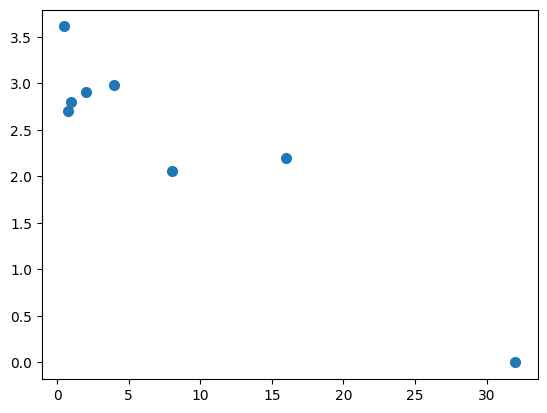

In [87]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter([0.5, 0.75, 1, 2, 4, 8, 16, 32], lf_hf, linewidth=2.0)
plt.show()